In [16]:
import h5py
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

In [11]:
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = 'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained\\'
sima_h5_path = root_dir + filename + '_sima_mc.h5'

In [ ]:
# trial windowing 

fs = 5
trial_window = [-]

In [12]:
# imaging data load
data_h5file = h5py.File(sima_h5_path, 'r')
data_h5file.keys()

<KeysViewHDF5 ['imaging']>

In [13]:
data_h5file['imaging'].shape

(15169, 1, 499, 490, 1)

In [23]:
#load trial info
glob_frame_files = glob.glob(root_dir + "framenumberforevents*")
frame_events = pickle.load( open( glob_frame_files[0], "rb" ), encoding="latin1" ) # latin1 b/c original pickle made in python 2


In [25]:
frame_events

{'plus_unrewarded': array([], dtype=float64),
 'licks': array([  103.,   118.,   473., ..., 15039., 15099., 15130.]),
 'minus_unrewarded': array([   35.,   308.,   580.,   644.,  1035.,  1879.,  2538.,  2816.,
         3674.,  3773.,  4252.,  4888.,  5017.,  5155.,  5391.,  5723.,
         6009.,  6434.,  6891.,  7028.,  7482.,  7716.,  8139.,  8338.,
         8512.,  9345.,  9426.,  9964., 10326., 10449., 10671., 10772.,
        10850., 10918., 11138., 11776., 12001., 12232., 12280., 13100.,
        13322., 13884., 13936., 14050., 14153., 14521., 14593., 14913.,
        14961., 15128.]),
 'minus_rewarded': array([], dtype=float64),
 'plus': array([  471.,   521.,   751.,  1104.,  1262.,  1329.,  1414.,  1491.,
         1589.,  1644.,  1817.,  2085.,  2351.,  2616.,  2982.,  3157.,
         3400.,  3627.,  3723.,  4304.,  4439.,  4525.,  5268.,  5781.,
         6235.,  6318.,  6642.,  7378.,  7802.,  8730.,  8928.,  9081.,
         9154.,  9884., 10180., 11252., 11360., 11566., 12047.,

CP_ALS: iteration 1, objective 0.8332517400318319, improvement inf.
CP_ALS: iteration 2, objective 0.44685831997224734, improvement 0.38639342005958455.
CP_ALS: iteration 3, objective 0.42155677577908013, improvement 0.025301544193167214.
CP_ALS: iteration 4, objective 0.41734006084153846, improvement 0.004216714937541666.
CP_ALS: iteration 5, objective 0.41703469862504283, improvement 0.00030536221649563045.
CP_ALS: iteration 6, objective 0.4170129075364675, improvement 2.1791088575306983e-05.
CP_ALS: iteration 7, objective 0.4170099062169335, improvement 3.0013195340128362e-06.
Converged after 7 iterations, 0.0061143 seconds. Objective: 0.4170099062169335.
CP_ALS: iteration 1, objective 0.8401788084827222, improvement inf.
CP_ALS: iteration 2, objective 0.5212416892508257, improvement 0.3189371192318965.
CP_ALS: iteration 3, objective 0.46492318910438885, improvement 0.056318500146436856.
CP_ALS: iteration 4, objective 0.42801140400126847, improvement 0.036911785103120376.
CP_ALS: it

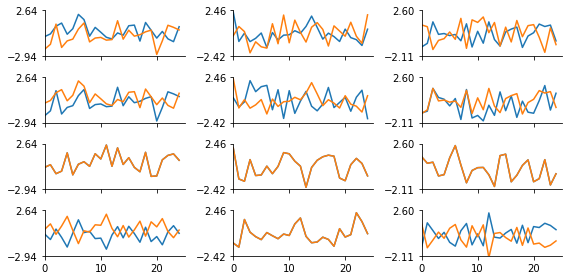

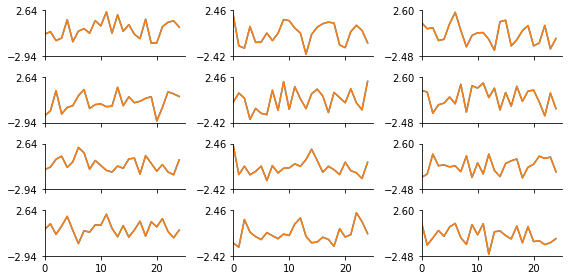

In [9]:
# Make synthetic dataset.
I, J, K, R = 25, 25, 25, 4  # dimensions and rank
X = tt.randn_ktensor((I, J, K), rank=R).full()
X += np.random.randn(I, J, K)  # add noise

# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Show plots.
plt.show()